In [1]:
import pandas as pd
import numpy as np
import os
import glob
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd
import wfdb
import statsmodels.api as sm
import matplotlib.image as mpimg
import tkinter as tk
from matplotlib.figure import Figure
from IPython.display import display, HTML
import csv
from collections import defaultdict
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
import pickle
from sklearn.linear_model import LogisticRegression
import tensorflow.keras as ks
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as Ks
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from numpy.random import seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
def getCNNModeltoInterpret(fname):
    learning_rate = 0.1
    momentum = 0.0
    model = ks.Sequential()
    # Conv Layer 1
    model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1, input_shape=(None,3),
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Conv Layer 2-11 (10 layers)
    for layernum in range(10):
        model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
    
    # Conv Layer 12
    model.add(ks.layers.Conv1D(filters=1, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    model.add(Activation('sigmoid'))
    previousModel = ks.models.load_model(fname)
    model.set_weights(previousModel.get_weights())
    return model

In [10]:
def getLSTMModeltoInterpret(fname):
    previousModel = ks.models.load_model(fname)
    model = Sequential()
    model.add(LSTM(100, input_shape=(None, 3),return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.set_weights(previousModel.get_weights())
    return model

In [8]:
def getLSTMSegMap(model, dfstat, data):
    TOTAL_LEN = np.shape(data)[0]

    mRR = dfstat['Mean'][dfstat['Parameter']=='RR'].values[0]
    sdRR = dfstat['StdDev'][dfstat['Parameter']=='RR'].values[0]
    mSpO2 = dfstat['Mean'][dfstat['Parameter']=='SpO2'].values[0]
    sdSpO2 = dfstat['StdDev'][dfstat['Parameter']=='SpO2'].values[0]
    mHR = dfstat['Mean'][dfstat['Parameter']=='HR'].values[0]
    sdHR = dfstat['StdDev'][dfstat['Parameter']=='HR'].values[0]

    rrnaf = (data['RRraw'].values - mRR)/sdRR
    spo2naf = (data['SpO2raw'].values - mSpO2)/sdSpO2
    hrnaf = (data['HRraw'].values - mHR)/sdHR
    
    X_TEST = np.zeros((1,TOTAL_LEN,3), dtype=np.float32)
    X_TEST[0,:,0] = rrnaf
    X_TEST[0,:,1] = spo2naf
    X_TEST[0,:,2] = hrnaf
    predictions = model.predict(X_TEST)
    return predictions[0,:,0]

In [4]:
def getCNNSegMap(model, dfstat, data):
    TOTAL_LEN = np.shape(data)[0]

    mRR = dfstat['Mean'][dfstat['Parameter']=='RR'].values[0]
    sdRR = dfstat['StdDev'][dfstat['Parameter']=='RR'].values[0]
    mSpO2 = dfstat['Mean'][dfstat['Parameter']=='SpO2'].values[0]
    sdSpO2 = dfstat['StdDev'][dfstat['Parameter']=='SpO2'].values[0]
    mHR = dfstat['Mean'][dfstat['Parameter']=='HR'].values[0]
    sdHR = dfstat['StdDev'][dfstat['Parameter']=='HR'].values[0]

    rrnaf = (data['RRraw'].values - mRR)/sdRR
    spo2naf = (data['SpO2raw'].values - mSpO2)/sdSpO2
    hrnaf = (data['HRraw'].values - mHR)/sdHR
    
    X_TEST = np.zeros((1,TOTAL_LEN,3), dtype=np.float32)
    X_TEST[0,:,0] = rrnaf
    X_TEST[0,:,1] = spo2naf
    X_TEST[0,:,2] = hrnaf
    predictions = model.predict(X_TEST)
    return predictions[0,:,0]

In [5]:
def movingAvg(x,n):
    y = np.zeros(len(x),dtype=np.float32)
    ysum = 0
    for i in range(len(x)):
        if(i<n):
            ysum += x[i]
            y[i] = ysum/float(i+1)
        else:
            ysum = ysum + x[i] - x[i-n]
            y[i] = ysum/float(n)
    return y

In [6]:
def getPosProbSAX(refProbDf, dfstat, data):
    mRR = dfstat['Mean'][dfstat['Parameter']=='RR'].values[0]
    sdRR = dfstat['StdDev'][dfstat['Parameter']=='RR'].values[0]
    mSpO2 = dfstat['Mean'][dfstat['Parameter']=='SpO2'].values[0]
    sdSpO2 = dfstat['StdDev'][dfstat['Parameter']=='SpO2'].values[0]
    mHR = dfstat['Mean'][dfstat['Parameter']=='HR'].values[0]
    sdHR = dfstat['StdDev'][dfstat['Parameter']=='HR'].values[0]
    tdf = pd.DataFrame(columns=['RR','SpO2','HR','nRR','nSpO2','nHR','symRR','symSpO2','symHR','Symbol','Label'])
    tdf['RR'] = data['RRraw'].values
    tdf['SpO2'] = data['SpO2raw'].values
    tdf['HR'] = data['HRraw'].values
    tdf['nRR'] = (data['RRraw'].values - mRR)/sdRR
    tdf['nSpO2'] = (data['SpO2raw'].values - mSpO2)/sdSpO2
    tdf['nHR'] = (data['HRraw'].values - mHR)/sdHR
    tdf['Label'] = data['Label'].values
    cutpoints = [-np.inf,-1.5,-1,-0.5,0,0.5,1,1.5,np.inf]
    tdf['symRR'] = pd.cut(tdf['nRR'], bins = cutpoints, labels=["A","B","C","D","E","F","G","H"])
    tdf['symSpO2'] = pd.cut(tdf['nSpO2'], bins = cutpoints, labels=["A","B","C","D","E","F","G","H"])
    tdf['symHR'] = pd.cut(tdf['nHR'], bins = cutpoints, labels=["A","B","C","D","E","F","G","H"])
    tdf['Symbol'] = tdf.apply(lambda row: row['symRR']+ row['symSpO2']+row['symHR'],axis=1)
    newtdf = pd.merge(tdf , refProbDf[['Symbol', 'PosProb']], how = 'left', left_on='Symbol', right_on='Symbol')
    return newtdf['PosProb'].values

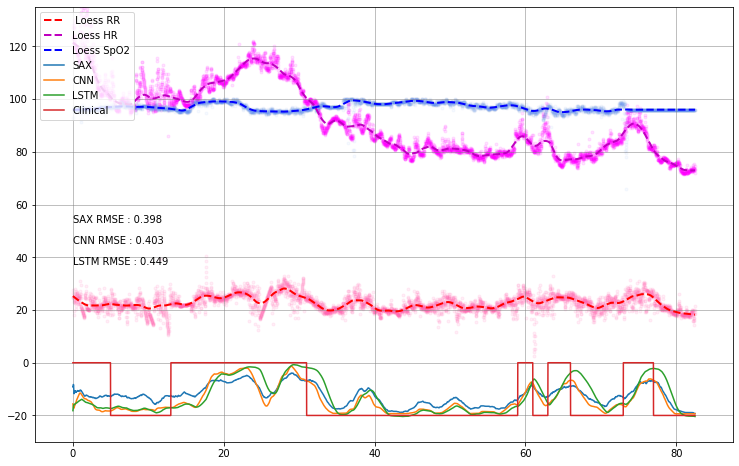

In [18]:
i = 143
refProbDf = pd.read_csv('SAXProb.csv')
dfstat = pd.read_csv(r'parStat.csv',sep=',')
fname = './SeriesSegData/p' + str(i).zfill(3) + '.csv'
data = pd.read_csv(fname,sep=',')
TOTAL_LEN = np.shape(data)[0]
t = np.arange(0,TOTAL_LEN,1)
x = t/60.0
y = data['Label'].values
model = getCNNModeltoInterpret('SegCNN.h5')
CNNpred = getCNNSegMap(model, dfstat, data)

SAXprob = getPosProbSAX(refProbDf, dfstat, data)

LSTMmodel = getLSTMModeltoInterpret('SegLSTM.h5')
LSTMpred = getLSTMSegMap(LSTMmodel, dfstat, data)

avgSAXprob = movingAvg(SAXprob,120)
avgCNNpred = movingAvg(CNNpred,120)
avgLSTMpred = movingAvg(LSTMpred,120)


xrr = data['RRraw'].values
xspo2 = data['SpO2raw'].values
xhr = data['HRraw'].values
Lrr = data['RRlowess'].values
Lspo2 = data['SpO2lowess'].values
Lhr = data['HRlowess'].values

fig = plt.figure(figsize=(12.5,8))
plt.clf()
ax = plt.axes(xlim=(-5,max(x)+5), ylim=(-30,135))

plt.scatter(x,xrr,c='hotpink',marker='.',alpha='0.1')
plt.scatter(x,xhr,c='magenta',marker='.',alpha='0.1')
plt.scatter(x,xspo2,c='cornflowerblue',marker='.',alpha='0.05')
plt.plot(x,Lrr,'--r',label=' Loess RR',linewidth=2)
plt.plot(x,Lhr,'--m',label='Loess HR',linewidth=2)
plt.plot(x,Lspo2,'--b',label='Loess SpO2',linewidth=2)
plt.plot(x,20*avgSAXprob - 20.0,label='SAX')
plt.plot(x,20*avgCNNpred - 20.0,label='CNN')
plt.plot(x,20*avgLSTMpred - 20.0, label= 'LSTM')
plt.plot(x,20*y - 20.0,label='Clinical')
plt.legend(loc=2)
error_sax = np.sqrt(sum(np.square(avgSAXprob - y))/TOTAL_LEN)
error_cnn = np.sqrt(sum(np.square(avgCNNpred - y))/TOTAL_LEN)
error_lstm = np.sqrt(sum(np.square(avgLSTMpred - y))/TOTAL_LEN)

sax_str = 'SAX RMSE : '+"{0:.3f}".format(error_sax)
cnn_str = 'CNN RMSE : '+"{0:.3f}".format(error_cnn)
lstm_str = 'LSTM RMSE : '+"{0:.3f}".format(error_lstm)
plt.text(0,53,sax_str, fontsize=10)
plt.text(0,45,cnn_str, fontsize=10)
plt.text(0,37,lstm_str, fontsize=10)
plt.grid(color='gray', linestyle='-', linewidth=0.5, which='both')
plt.show()